# Notebook 03: Training Pipeline

## Pancreas CT Segmentation using TransUNet

This notebook covers:
1. Dataset preparation with SlicingDataset
2. Hybrid Loss function (Dice + CrossEntropy)
3. Training configuration
4. Training loop with validation
5. Checkpointing and logging

## 1. Environment Setup

In [1]:
import os
import sys
import json
import time
from pathlib import Path
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR

import monai
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.data import decollate_batch
from monai.transforms import AsDiscrete

# Add src to path (handle notebook running from notebooks/ folder)
parent_dir = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
if str(parent_dir) not in sys.path:
    sys.path.insert(0, str(parent_dir))

# Import custom modules
from src.model import create_transunet
from src.dataset import SlicingDataset
from src.transforms import get_train_transforms, get_val_transforms
from src.loss import HybridLoss
from src.utils import plot_training_history

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

Using device: cpu


In [2]:
# Configuration
# Determine project root (handle notebook running from notebooks/ folder)
project_root = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()

CONFIG = {
    # Data
    "data_dir": project_root / "data" / "Task07_Pancreas",
    "splits_path": project_root / "outputs" / "data_splits.json",
    "checkpoint_dir": project_root / "checkpoints",
    
    # Model
    "img_size": 224,
    "in_channels": 1,
    "out_channels": 2,  # Background + Pancreas (merge tumor with pancreas)
    "model_variant": "small",  # Use small for faster training, base for best results
    
    # Training
    "batch_size": 8,
    "num_epochs": 50,
    "learning_rate": 1e-4,
    "weight_decay": 1e-5,
    
    # Loss
    "dice_weight": 0.5,
    "ce_weight": 0.5,
    
    # Data loading
    "num_workers": 0,  # Set to 0 for Windows compatibility
    "cache_data": False,  # Set True if you have enough RAM
    
    # Misc
    "seed": 42,
    "val_interval": 1,  # Validate every N epochs
    "save_interval": 5,  # Save checkpoint every N epochs
}

# Create checkpoint directory
CONFIG["checkpoint_dir"].mkdir(exist_ok=True)

# Set random seeds
torch.manual_seed(CONFIG["seed"])
np.random.seed(CONFIG["seed"])

print("Configuration:")
print(f"Project root: {project_root}")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

Configuration:
Project root: c:\Users\LENOVO\Desktop\Đồ Án Tốt Nghiệp
  data_dir: c:\Users\LENOVO\Desktop\Đồ Án Tốt Nghiệp\data\Task07_Pancreas
  splits_path: c:\Users\LENOVO\Desktop\Đồ Án Tốt Nghiệp\outputs\data_splits.json
  checkpoint_dir: c:\Users\LENOVO\Desktop\Đồ Án Tốt Nghiệp\checkpoints
  img_size: 224
  in_channels: 1
  out_channels: 2
  model_variant: small
  batch_size: 8
  num_epochs: 50
  learning_rate: 0.0001
  weight_decay: 1e-05
  dice_weight: 0.5
  ce_weight: 0.5
  num_workers: 0
  cache_data: False
  seed: 42
  val_interval: 1
  save_interval: 5


## 2. Load Data Splits

In [3]:
# Load data splits
with open(CONFIG["splits_path"], "r") as f:
    data_splits = json.load(f)

print(f"Train samples: {len(data_splits['train'])}")
print(f"Val samples: {len(data_splits['val'])}")
print(f"Test samples: {len(data_splits['test'])}")

Train samples: 225
Val samples: 28
Test samples: 29


In [4]:
# Limit samples for faster testing (remove in production)
MAX_TRAIN_SAMPLES = 20  # Use None for all samples
MAX_VAL_SAMPLES = 5

if MAX_TRAIN_SAMPLES:
    train_data = data_splits["train"][:MAX_TRAIN_SAMPLES]
    val_data = data_splits["val"][:MAX_VAL_SAMPLES]
    print(f"\nUsing limited samples for testing:")
    print(f"  Train: {len(train_data)}")
    print(f"  Val: {len(val_data)}")
else:
    train_data = data_splits["train"]
    val_data = data_splits["val"]


Using limited samples for testing:
  Train: 20
  Val: 5


## 3. Create Datasets and DataLoaders

In [5]:
# Get transforms
train_transforms = get_train_transforms()
val_transforms = get_val_transforms()

print("Creating datasets...")
print("This may take a while as volumes are being indexed...")

Creating datasets...
This may take a while as volumes are being indexed...


c:\Users\LENOVO\Desktop\Đồ Án Tốt Nghiệp\.venv\Lib\site-packages\monai\utils\deprecate_utils.py:321: FutureWarning: monai.transforms.spatial.dictionary Orientationd.__init__:labels: Current default value of argument `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` was changed in version None from `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` to `labels=None`. Default value changed to None meaning that the transform now uses the 'space' of a meta-tensor, if applicable, to determine appropriate axis labels.
  warn_deprecated(argname, msg, warning_category)


In [6]:
# Create SlicingDataset for training
train_dataset = SlicingDataset(
    data_list=train_data,
    transform=train_transforms,
    slice_axis=0,  # Axial slices
    include_empty=False,  # Only slices with pancreas
    cache_data=CONFIG["cache_data"],
    target_size=(CONFIG["img_size"], CONFIG["img_size"]),
)

print(f"\nTrain dataset: {len(train_dataset)} slices")

Building slice index...
Total slices: 2568

Train dataset: 2568 slices
Total slices: 2568

Train dataset: 2568 slices


In [7]:
# Create SlicingDataset for validation
val_dataset = SlicingDataset(
    data_list=val_data,
    transform=val_transforms,
    slice_axis=0,
    include_empty=False,
    cache_data=CONFIG["cache_data"],
    target_size=(CONFIG["img_size"], CONFIG["img_size"]),
)

print(f"Val dataset: {len(val_dataset)} slices")

Building slice index...
Total slices: 601
Val dataset: 601 slices
Total slices: 601
Val dataset: 601 slices


In [8]:
# Create DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG["batch_size"],
    shuffle=True,
    num_workers=CONFIG["num_workers"],
    pin_memory=True if torch.cuda.is_available() else False,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG["batch_size"],
    shuffle=False,
    num_workers=CONFIG["num_workers"],
    pin_memory=True if torch.cuda.is_available() else False,
)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

Train batches: 321
Val batches: 76



Batch shapes:
  Images: torch.Size([8, 1, 224, 224])
  Labels: torch.Size([8, 224, 224])


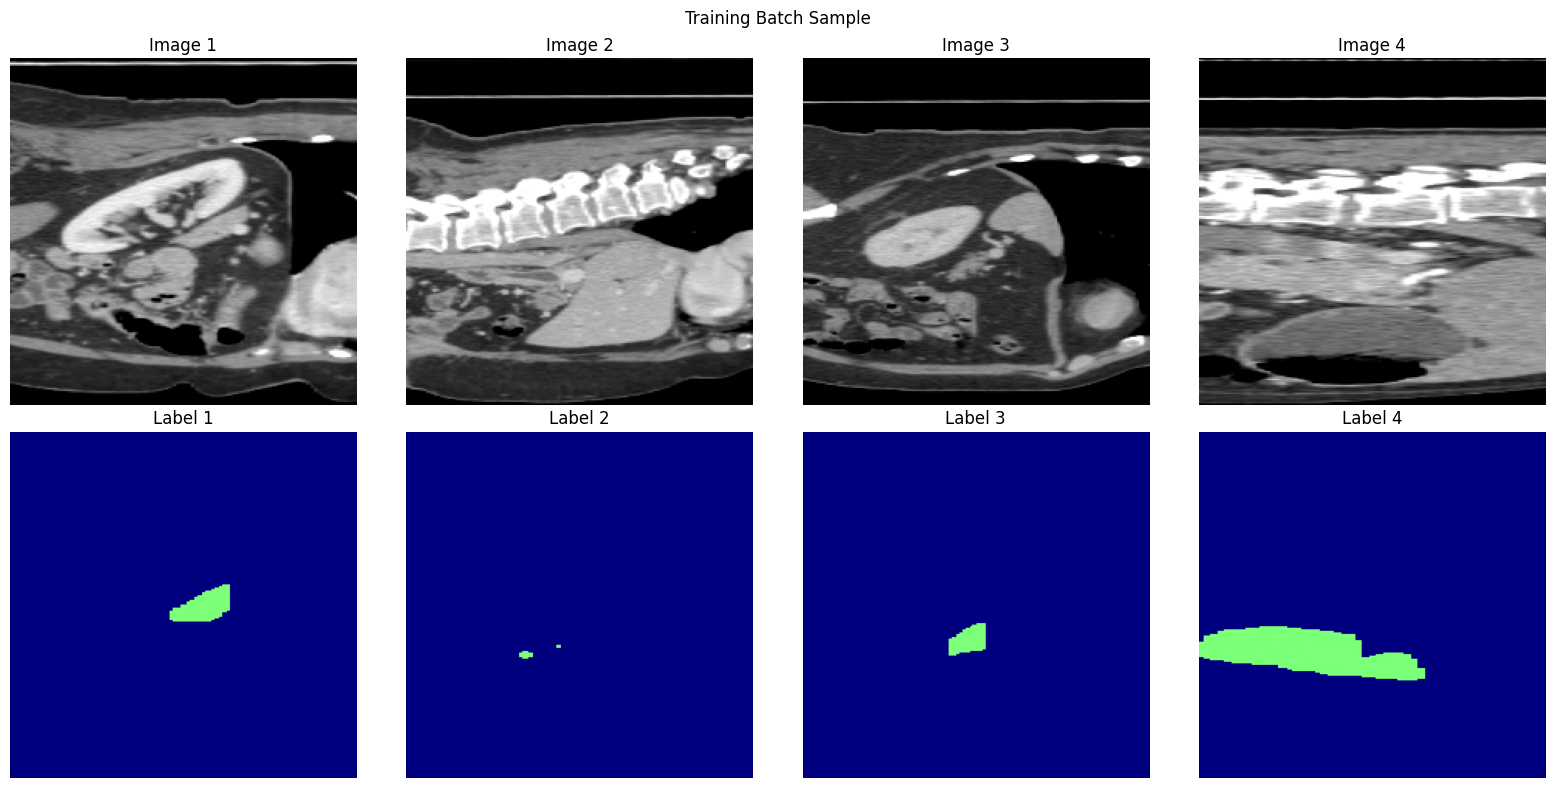

In [9]:
# Visualize a batch
sample_images, sample_labels = next(iter(train_loader))
print(f"\nBatch shapes:")
print(f"  Images: {sample_images.shape}")
print(f"  Labels: {sample_labels.shape}")

# Show samples
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for i in range(4):
    axes[0, i].imshow(sample_images[i, 0].numpy(), cmap="gray")
    axes[0, i].set_title(f"Image {i+1}")
    axes[0, i].axis("off")
    
    axes[1, i].imshow(sample_labels[i].numpy(), cmap="jet", vmin=0, vmax=2)
    axes[1, i].set_title(f"Label {i+1}")
    axes[1, i].axis("off")

plt.suptitle("Training Batch Sample")
plt.tight_layout()
plt.show()

## 4. Create Model, Loss, Optimizer

In [10]:
# Create model
model = create_transunet(
    img_size=CONFIG["img_size"],
    in_channels=CONFIG["in_channels"],
    out_channels=CONFIG["out_channels"],
    variant=CONFIG["model_variant"],
)
model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


Total parameters: 16,960,130
Trainable parameters: 16,960,130


In [11]:
# Create loss function
criterion = HybridLoss(
    dice_weight=CONFIG["dice_weight"],
    ce_weight=CONFIG["ce_weight"],
    num_classes=CONFIG["out_channels"],
)

print(f"Loss function: HybridLoss (Dice={CONFIG['dice_weight']}, CE={CONFIG['ce_weight']})")

Loss function: HybridLoss (Dice=0.5, CE=0.5)


In [12]:
# Create optimizer
optimizer = optim.AdamW(
    model.parameters(),
    lr=CONFIG["learning_rate"],
    weight_decay=CONFIG["weight_decay"],
)

# Create learning rate scheduler
scheduler = CosineAnnealingLR(
    optimizer,
    T_max=CONFIG["num_epochs"],
    eta_min=1e-6,
)

print(f"Optimizer: AdamW (lr={CONFIG['learning_rate']}, weight_decay={CONFIG['weight_decay']})")
print(f"Scheduler: CosineAnnealingLR (T_max={CONFIG['num_epochs']})")

Optimizer: AdamW (lr=0.0001, weight_decay=1e-05)
Scheduler: CosineAnnealingLR (T_max=50)


In [13]:
# Create metrics
dice_metric = DiceMetric(
    include_background=False,  # Exclude background from metric
    reduction="mean",
)

# Post-processing transforms
post_pred = AsDiscrete(argmax=True, to_onehot=CONFIG["out_channels"])
post_label = AsDiscrete(to_onehot=CONFIG["out_channels"])

print("Metric: DiceMetric (excluding background)")

Metric: DiceMetric (excluding background)


## 5. Training Loop

In [14]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    """
    Train for one epoch.
    
    Returns:
        Average training loss
    """
    model.train()
    total_loss = 0.0
    num_batches = 0
    
    pbar = tqdm(loader, desc="Training", leave=False)
    for images, labels in pbar:
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        num_batches += 1
        
        pbar.set_postfix({"loss": f"{loss.item():.4f}"})
    
    return total_loss / num_batches


def validate(model, loader, criterion, dice_metric, post_pred, post_label, device):
    """
    Validate the model.
    
    Returns:
        Tuple of (average loss, dice score)
    """
    model.eval()
    total_loss = 0.0
    num_batches = 0
    
    dice_metric.reset()
    
    with torch.no_grad():
        pbar = tqdm(loader, desc="Validation", leave=False)
        for images, labels in pbar:
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            num_batches += 1
            
            # Compute Dice score
            outputs_list = decollate_batch(outputs)
            labels_list = decollate_batch(labels.unsqueeze(1))
            
            outputs_post = [post_pred(o) for o in outputs_list]
            labels_post = [post_label(l) for l in labels_list]
            
            dice_metric(y_pred=outputs_post, y=labels_post)
    
    avg_loss = total_loss / num_batches
    dice_score = dice_metric.aggregate().item()
    
    return avg_loss, dice_score

In [15]:
# Training history
history = {
    "train_loss": [],
    "val_loss": [],
    "val_dice": [],
    "lr": [],
}

best_dice = 0.0
best_epoch = 0

print(f"\nStarting training for {CONFIG['num_epochs']} epochs...")
print("="*60)


Starting training for 50 epochs...


In [ ]:
# Main training loop
for epoch in range(1, CONFIG["num_epochs"] + 1):
    epoch_start = time.time()
    
    # Training
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
    history["train_loss"].append(train_loss)
    
    # Validation
    if epoch % CONFIG["val_interval"] == 0:
        val_loss, val_dice = validate(
            model, val_loader, criterion, dice_metric,
            post_pred, post_label, device
        )
        history["val_loss"].append(val_loss)
        history["val_dice"].append(val_dice)
    else:
        val_loss = history["val_loss"][-1] if history["val_loss"] else 0
        val_dice = history["val_dice"][-1] if history["val_dice"] else 0
    
    # Learning rate
    current_lr = optimizer.param_groups[0]["lr"]
    history["lr"].append(current_lr)
    scheduler.step()
    
    # Checkpoint if best
    if val_dice > best_dice:
        best_dice = val_dice
        best_epoch = epoch
        torch.save({
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "best_dice": best_dice,
            "config": CONFIG,
        }, CONFIG["checkpoint_dir"] / "best_metric_model.pth")
        save_msg = " [BEST - Saved]"
    else:
        save_msg = ""
    
    # Periodic checkpoint
    if epoch % CONFIG["save_interval"] == 0:
        torch.save({
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "history": history,
        }, CONFIG["checkpoint_dir"] / f"checkpoint_epoch_{epoch}.pth")
    
    epoch_time = time.time() - epoch_start
    
    # Print progress
    print(
        f"Epoch {epoch:3d}/{CONFIG['num_epochs']} | "
        f"Train Loss: {train_loss:.4f} | "
        f"Val Loss: {val_loss:.4f} | "
        f"Val Dice: {val_dice:.4f} | "
        f"LR: {current_lr:.2e} | "
        f"Time: {epoch_time:.1f}s{save_msg}"
    )

print("="*60)
print(f"Training complete!")
print(f"Best Dice Score: {best_dice:.4f} at epoch {best_epoch}")

Training:   2%|▏         | 6/321 [03:54<3:55:06, 44.78s/it, loss=0.7612]

## 6. Training Visualization

In [ ]:
# Plot training history
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

epochs = range(1, len(history["train_loss"]) + 1)

# Loss curves
axes[0].plot(epochs, history["train_loss"], "b-", label="Train Loss", linewidth=2)
if history["val_loss"]:
    val_epochs = range(CONFIG["val_interval"], len(history["train_loss"]) + 1, CONFIG["val_interval"])
    axes[0].plot(val_epochs, history["val_loss"], "r-", label="Val Loss", linewidth=2)
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Training and Validation Loss")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Dice score curve
if history["val_dice"]:
    val_epochs = range(CONFIG["val_interval"], len(history["train_loss"]) + 1, CONFIG["val_interval"])
    axes[1].plot(val_epochs, history["val_dice"], "g-", label="Val Dice", linewidth=2)
    axes[1].axhline(y=best_dice, color="r", linestyle="--", label=f"Best: {best_dice:.4f}")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Dice Score")
axes[1].set_title("Validation Dice Score")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Learning rate curve
axes[2].plot(epochs, history["lr"], "purple", linewidth=2)
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("Learning Rate")
axes[2].set_title("Learning Rate Schedule")
axes[2].set_yscale("log")
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(CONFIG["checkpoint_dir"] / "training_curves.png", dpi=150)
plt.show()

In [ ]:
# Save training history
history_path = CONFIG["checkpoint_dir"] / "training_history.json"
with open(history_path, "w") as f:
    json.dump(history, f, indent=2)
print(f"Training history saved to: {history_path}")

## 7. Quick Inference Test

In [ ]:
# Load best model
checkpoint = torch.load(CONFIG["checkpoint_dir"] / "best_metric_model.pth")
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

print(f"Loaded best model from epoch {checkpoint['epoch']} with Dice={checkpoint['best_dice']:.4f}")

In [ ]:
# Get sample predictions
sample_images, sample_labels = next(iter(val_loader))
sample_images = sample_images.to(device)

with torch.no_grad():
    predictions = model(sample_images)
    predictions = torch.argmax(predictions, dim=1)

# Visualize
fig, axes = plt.subplots(3, 4, figsize=(16, 12))

for i in range(4):
    # Original image
    axes[0, i].imshow(sample_images[i, 0].cpu().numpy(), cmap="gray")
    axes[0, i].set_title("Input CT")
    axes[0, i].axis("off")
    
    # Ground truth
    axes[1, i].imshow(sample_images[i, 0].cpu().numpy(), cmap="gray")
    gt_mask = np.ma.masked_where(sample_labels[i].numpy() == 0, sample_labels[i].numpy())
    axes[1, i].imshow(gt_mask, cmap="Greens", alpha=0.6, vmin=0, vmax=2)
    axes[1, i].set_title("Ground Truth")
    axes[1, i].axis("off")
    
    # Prediction
    axes[2, i].imshow(sample_images[i, 0].cpu().numpy(), cmap="gray")
    pred_mask = np.ma.masked_where(predictions[i].cpu().numpy() == 0, predictions[i].cpu().numpy())
    axes[2, i].imshow(pred_mask, cmap="Reds", alpha=0.6, vmin=0, vmax=2)
    axes[2, i].set_title("Prediction")
    axes[2, i].axis("off")

plt.suptitle("Model Predictions on Validation Set", fontsize=14)
plt.tight_layout()
plt.savefig(CONFIG["checkpoint_dir"] / "sample_predictions.png", dpi=150)
plt.show()

## Summary

This notebook implemented the complete training pipeline:

1. **SlicingDataset**: Extracts 2D axial slices from 3D CT volumes, filtering to include only slices with pancreas labels

2. **HybridLoss**: Combines Dice Loss and Cross-Entropy Loss with configurable weights (0.5 each by default)

3. **Training Configuration**:
   - Optimizer: AdamW with learning rate 1e-4
   - Scheduler: CosineAnnealingLR
   - Metric: DiceMetric (excluding background)

4. **Training Loop**:
   - Forward pass -> Loss computation -> Backward pass -> Optimizer step
   - Validation with Dice score computation
   - Best model checkpointing

5. **Outputs**:
   - `checkpoints/best_metric_model.pth`: Best model weights
   - `checkpoints/training_history.json`: Loss and metric history
   - `checkpoints/training_curves.png`: Training visualization

Next: Notebook 04 - Evaluation and Demo